<a href="https://colab.research.google.com/github/SS-yong/Federated-Learning/blob/main/HAR_using_FL_230224.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center> Colab Data Setting </center>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/FL')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/FL'

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Dropout,Flatten,InputLayer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import warnings
import time
warnings.filterwarnings(action = 'ignore')

In [ ]:
features = []

with open("UCI HAR Dataset/features.txt") as file:
    for line in file:
        features.append(line.split()[1])

u, c = np.unique(features, return_counts=True)
dups = u[c > 1]
features = np.array(features)
for dup in dups:
    idx = np.where(features == dup)[0]
    i = 0
    for n in idx:
        features[n] = f'{features[n]}({i+1})'
        i += 1

train_df = pd.read_csv('UCI HAR Dataset/train/X_train.txt', delim_whitespace = True, names = features)
train_df['id'] = pd.read_csv('UCI HAR Dataset/train/subject_train.txt', header = None)
activity = pd.read_csv('UCI HAR Dataset/train/y_train.txt', header = None, squeeze = True)
train_df['label'] = activity
label_name = activity.map({1: "WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4:"SITTING", 5:"STANDING", 6:"LYING"})
train_df['activity_name'] = label_name
train_df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",id,label,activity_name
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,5,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,5,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,5,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,5,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,5,STANDING


In [ ]:
test_df = pd.read_csv('UCI HAR Dataset/test/X_test.txt', delim_whitespace = True, names = features)
test_df['id'] = pd.read_csv('UCI HAR Dataset/test/subject_test.txt', header = None)
activity = pd.read_csv('UCI HAR Dataset/test/y_test.txt', header = None, squeeze = True)
test_df['label'] = activity
label_name = activity.map({1: "WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4:"SITTING", 5:"STANDING", 6:"LYING"})
test_df['activity_name'] = label_name
test_df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",id,label,activity_name
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,2,5,STANDING
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,2,5,STANDING
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,2,5,STANDING
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,2,5,STANDING
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,2,5,STANDING


In [ ]:
df = pd.concat([train_df, test_df])
df.reset_index(drop = True, inplace = True)

<center> Data Distribution(EDA) </center>

<AxesSubplot:xlabel='id', ylabel='activity_name'>

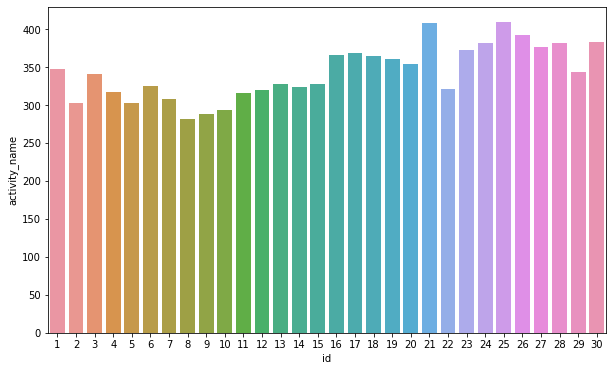

In [ ]:
# is data imbalanced
dist_id = df.loc[:, ['id', 'activity_name']].groupby(by = 'id').count().reset_index()
plt.figure(figsize = (10, 6))
sns.barplot(x = dist_id.id, y = dist_id.activity_name)

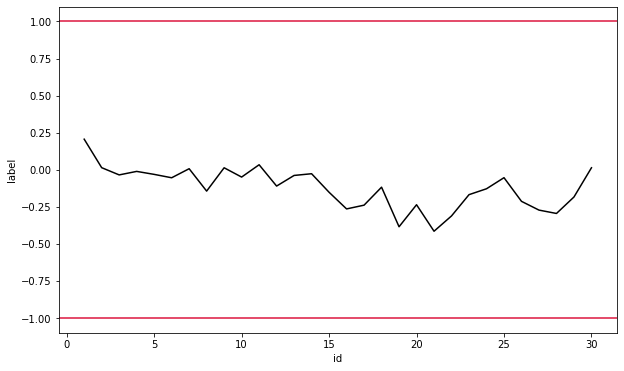

In [ ]:
# is data skewed
skew_id = df.loc[:, ['id', 'label']].groupby(by = 'id').skew().reset_index()
plt.figure(figsize = (10, 6))
sns.lineplot(x = skew_id.id, y = skew_id.label, color = 'k')
plt.axhline(1, color = 'crimson')
plt.axhline(-1, color = 'crimson')

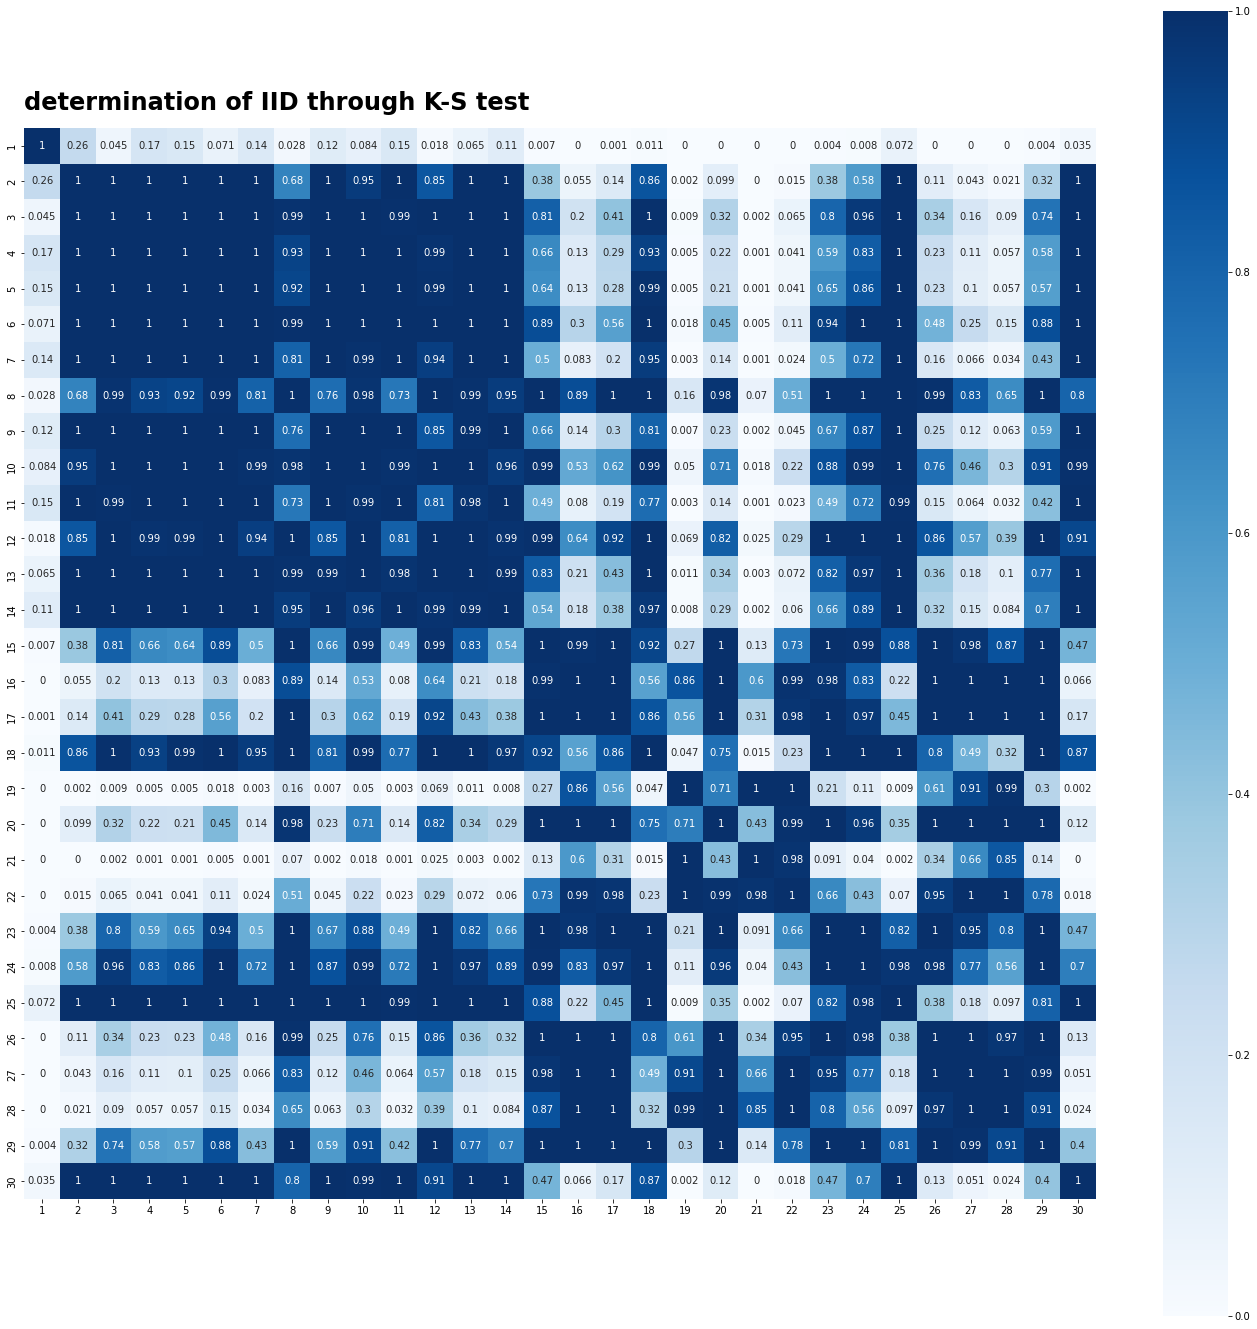

In [ ]:
# is data non-iid?
from scipy.stats import ks_2samp

clients = np.unique(df.id)
matrix = [[0]*len(clients) for _ in range(len(clients))]
for i in clients:
    data1 = df[df.id == i]['label']
    for j in clients:
        data2 = df[df.id == j]['label']
        _, p_value = ks_2samp(data1, data2)
        matrix[i-1][j-1] = p_value

matrix = pd.DataFrame(matrix, index = clients, columns = clients)

plt.figure(figsize = (24, 24))
sns.heatmap(round(matrix, 3), annot = True, cmap = "Blues", square = True, annot_kws = {"size" : 10})
plt.text(0, -0.5, "determination of IID through K-S test", {"size": 24, "weight": "bold"})
plt.show()

Local clients are not skewed distribution, but they are imbalanced. In addition, as a result of checking each other's IIDs through the kolmogorov-smirnov test, it was confirmed that only some clients were IIDs. (At this time, the significance level was set to 0.05) Accordingly, it was confirmed that the UCI-HAR Dataset was a non-IID Dataset.

<center> Federated Learning </center>

In [ ]:
epochs = 10
batch_size = 64

def preprocess(df):
    X = df.loc[:, ~df.columns.isin(['id', 'label', 'activity_name'])]
    y = df.loc[:, 'label']
    scaler = MinMaxScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    y = np.array(y)-1
    return X, y

def create_model(input_shape):
    model = Sequential()
    model.add(InputLayer(input_shape = input_shape,))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(6, activation ='softmax'))
    return model

def model_compile(model):
    model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )
    return model;

def model_fit(model,X,y,i, case_number):
    history = model.fit(X, y,validation_split=0.2,
    batch_size = batch_size, epochs = epochs, verbose=0,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(f'model/model{case_number}_{i}.h5', save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=5
        )
    ])
    return model

def load_models(clients, case_number):
    models = []
    for i in clients:
        model = load_model(f'model/model{case_number}_{i}.h5')
        models.append(model)
    return models

def fedavg(models):
    models = np.array(models)
    avg_model_weights = []
    n_models = len(models)
    n_layers = len(models[0].get_weights())
    for layer in range(n_layers):
        layer_weights = np.array([model.get_weights()[layer] for model in models])
        avg_layer_weights = np.average(layer_weights, axis=0)
        avg_model_weights.append(avg_layer_weights)
    return avg_model_weights

def federated_learning(train_df, test_df, case_number, rounds = 5, c = 0.5):
    print(f'Case {case_number}')
    start = time.time()
    
    # split shared dataset and local dataset (ref. Federated Learning with Non-IID Data(2018)) 
    clients_df, shared_df = train_test_split(train_df, test_size = 0.2)
    shared_df.reset_index(drop = True, inplace = True)
    X_shared, y_shared = preprocess(shared_df)
    
    # train model by shared dataset from central server to be sent to each local client
    model_0 = create_model(X_shared.shape[1])
    model_0 = model_compile(model_0)
    model_0 = model_fit(model_0, X_shared, y_shared, 0, case_number)
    
    # train model by each local dataset from local client
    clients = np.unique(train_df.id)
    for client in clients:
        globals()[f'model{case_number}_{client}'] = create_model(X_shared.shape[1])
        globals()[f'model{case_number}_{client}'] = model_compile(globals()[f'model{case_number}_{client}'])
        globals()[f'model{case_number}_{client}'].set_weights(model_0.get_weights())
        
        client_df = clients_df[clients_df.id == client].reset_index(drop = True)
        
        # train model by subsampling dataset in each round
        for i in range(rounds):
            try:
                round_df = client_df.sample(frac = c, replace = True)
                X_train, y_train = preprocess(round_df)
                globals()[f'model{case_number}_{client}'] = model_fit(globals()[f'model{case_number}_{client}'], X_train, y_train, client, case_number)
            except:
                continue
    
    # test global model
    X_test, y_test = preprocess(test_df)
    models = load_models(clients, case_number)

    global_model = create_model(X_shared.shape[1])
    global_model = model_compile(global_model)
    global_model.set_weights(fedavg(models))
    
    _, accuracy = global_model.evaluate(X_test, y_test, verbose = 0)
    print(f'no threshold accuracy: {round(accuracy*100,2)}%')
    
    # test global model with threshold
    thresholds = np.arange(75, 100, 5)/100    
    for threshold in thresholds:
        high_models = []
        for i in clients:
            _, accuracy = globals()[f'model{case_number}_{i}'].evaluate(X_test, y_test, verbose = 0)
            if accuracy > threshold:
                model = load_model(f'model/model{case_number}_{i}.h5')
                high_models.append(model)
        try:
            global_model.set_weights(fedavg(high_models))
            _, accuracy = global_model.evaluate(X_test, y_test, verbose = 0)
            print(f'threshold: {threshold}, accuracy: {round(accuracy*100,2)}%')
        except:
            print(f'threshold: {threshold}, no model over threshold')
    
    print('runtime:', time.time() - start)
    return models

<center> < Case 1 : When we didn't have new clients > </center>
Becuase UCI-HAR dataset is composed of train/test set(70:30), There is a problem that the person in the train set is not in the test set. So, union two datasets, and re-split them to distribute evenly each clients in tran/test set. <br>

In [ ]:
train_df1, test_df1 = train_test_split(df, test_size = 0.3)
train_df1.reset_index(drop = True, inplace = True)
test_df1.reset_index(drop = True, inplace = True)

In [ ]:
models_1 = federated_learning(train_df1, test_df1, case_number = 1, rounds = 10)

Case 1
no threshold accuracy: 80.19%
threshold: 0.75, accuracy: 83.53%
threshold: 0.8, accuracy: 84.92%
threshold: 0.85, no model over threshold
threshold: 0.9, no model over threshold
threshold: 0.95, no model over threshold
runtime: 410.4805727005005


<center> Case 2: When we had new clients </center>

In [ ]:
models_2 = federated_learning(train_df, test_df, case_number = 2, rounds = 10)

Case 2
no threshold accuracy: 90.5%
threshold: 0.75, accuracy: 90.53%
threshold: 0.8, accuracy: 90.46%
threshold: 0.85, accuracy: 90.53%
threshold: 0.9, accuracy: 91.41%
threshold: 0.95, no model over threshold
runtime: 291.29919838905334


<center> Report </center>
<br>
According to EDA, it was confirmed that the UCI-HAR Dataset was a non-iid Dataset with a different distribution for each client. Accordingly, referring to 
Federated Learning with Non-IID Data (2018), it is assumed that some data from other local clients is shared in the Dataset of each local client. In addition, it is assumed that the factor that lowers the accuracy of the global model is the weight difference of the local model, and the shared data is learned in advance from the central server and the weight of the model is transferred to the local client.

As a result, when c = 0.5 and round = 10 were set in Case 1, the accuracy of the global model was about 0.85, and when threshold was placed with reference to Human Activity Recognition with Federated Learning (2018), the following accuracy was obtained.

< Case 1 > <br>
no threshold accuracy: 80.19% <br>
threshold: 0.75, accuracy: 83.53% <br>
threshold: 0.8, accuracy: 84.92% <br>
threshold: 0.85, no model over threshold <br>
threshold: 0.9, no model over threshold <br>
threshold: 0.95, no model over threshold <br>

Case 2 was also set to c = 0.5 and round = 10, and the accuracy was as follows.

no threshold accuracy: 90.5% <br>
threshold: 0.75, accuracy: 90.53% <br>
threshold: 0.8, accuracy: 90.46% <br>
threshold: 0.85, accuracy: 90.53% <br>
threshold: 0.9, accuracy: 91.41% <br>
threshold: 0.95, no model over threshold <br>

In addition, when repeatedly performed on the same code several times, the accuracy increased, and we empirically confirmed that the accuracy increased as the round continued.

However, it is highly likely that the above notebook shared server resources because each client and central server were used in the same server environment. As a result, it is difficult to say that it is strict federated learning.

<img src = "https://drive.google.com/uc?id=13hIfdSAHRAx1pdaCUI7g4Q8-pey8rfQm">


Federated Learning with Non-IID Data(2018)

<img src = 'https://drive.google.com/uc?id=1mPwb5WW37hWN8q41UAl5Z8mkNjsmGJHt'>

Illustration of the above code